In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, precision_score, recall_score, classification_report

from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Micro-credit-Data-file.csv")

print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (209593, 37)


,Unnamed: 0,label,msisdn,aon,daily_decr30,daily_decr90,rental30,rental90,last_rech_date_ma,last_rech_date_da,...,maxamnt_loans30,medianamnt_loans30,cnt_loans90,amnt_loans90,maxamnt_loans90,medianamnt_loans90,payback30,payback90,pcircle,pdate
0,1,0,21408I70789,272.0,3055.050000,3065.150000,220.13,260.13,2.0,0.0,...,6.0,0.0,2.0,12,6,0.0,29.000000,29.000000,UPW,2016-07-20
1,2,1,76462I70374,712.0,12122.000000,12124.750000,3691.26,3691.26,20.0,0.0,...,12.0,0.0,1.0,12,12,0.0,0.000000,0.000000,UPW,2016-08-10
2,3,1,17943I70372,535.0,1398.000000,1398.000000,900.13,900.13,3.0,0.0,...,6.0,0.0,1.0,6,6,0.0,0.000000,0.000000,UPW,2016-08-19
3,4,1,55773I70781,241.0,21.228000,21.228000,159.42,159.42,41.0,0.0,...,6.0,0.0,2.0,12,6,0.0,0.000000,0.000000,UPW,2016-06-06
4,5,1,03813I82730,947.0,150.619333,150.619333,1098.90,1098.90,4.0,0.0,...,6.0,0.0,7.0,42,6,0.0,2.333333,2.333333,UPW,2016-06-22


In [3]:
print("\nMissing Values:\n", df.isnull().sum())

# Impute missing values (mean for numeric, most frequent for categorical)
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns

imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

df[num_cols] = imputer_num.fit_transform(df[num_cols])
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])


Missing Values:
 Unnamed: 0              0
label                   0
msisdn                  0
aon                     0
daily_decr30            0
daily_decr90            0
rental30                0
rental90                0
last_rech_date_ma       0
last_rech_date_da       0
last_rech_amt_ma        0
cnt_ma_rech30           0
fr_ma_rech30            0
sumamnt_ma_rech30       0
medianamnt_ma_rech30    0
medianmarechprebal30    0
cnt_ma_rech90           0
fr_ma_rech90            0
sumamnt_ma_rech90       0
medianamnt_ma_rech90    0
medianmarechprebal90    0
cnt_da_rech30           0
fr_da_rech30            0
cnt_da_rech90           0
fr_da_rech90            0
cnt_loans30             0
amnt_loans30            0
maxamnt_loans30         0
medianamnt_loans30      0
cnt_loans90             0
amnt_loans90            0
maxamnt_loans90         0
medianamnt_loans90      0
payback30               0
payback90               0
pcircle                 0
pdate                   0
dtype: int64


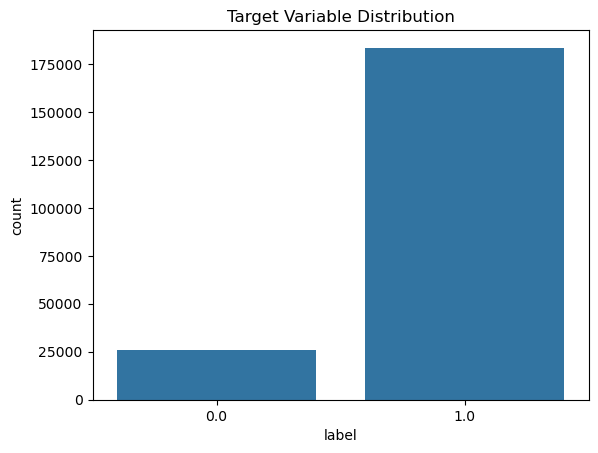

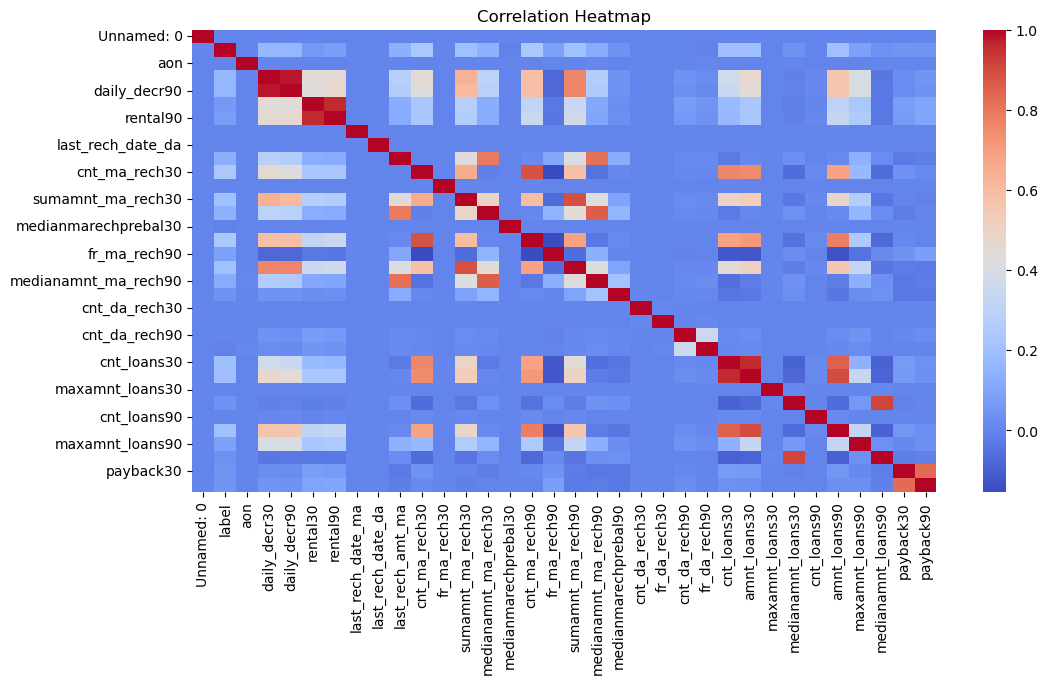

In [4]:
sns.countplot(x='label', data=df)
plt.title("Target Variable Distribution")
plt.show()

# Example correlation heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df[num_cols].corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [5]:
from sklearn.preprocessing import LabelEncoder

# ================================
# Feature Engineering
# ================================

# Example engineered features
if 'loan_amount' in df.columns and 'income' in df.columns:
    df['loan_to_income'] = df['loan_amount'] / (df['income'] + 1)

if 'days_since_last_loan' in df.columns:
    df['recent_loan'] = (df['days_since_last_loan'] < 30).astype(int)

# Drop pure identifiers (very high cardinality, not predictive)
id_like_cols = [col for col in df.columns if 'id' in col.lower() or 'phone' in col.lower()]
df = df.drop(columns=id_like_cols, errors='ignore')

# Update categorical column list
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

# Encoding strategy
low_card_cols = [col for col in cat_cols if df[col].nunique() <= 20]
high_card_cols = [col for col in cat_cols if df[col].nunique() > 20]

# 1. One-hot encode low-cardinality categoricals
df = pd.get_dummies(df, columns=low_card_cols, drop_first=True)

# 2. Label encode high-cardinality categoricals
le = LabelEncoder()
for col in high_card_cols:
    df[col] = le.fit_transform(df[col])

# Final check
print("Final shape after encoding:", df.shape)


Final shape after encoding: (209593, 36)


In [7]:
df_sample = df.sample(n=30000, random_state=42)

# Example preprocessing (replace with your own)
X = df_sample.drop(columns=['label'])  # target col name example
y = df_sample['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, BaggingClassifier, HistGradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

models = [
    ("LogReg_v1", LogisticRegression(max_iter=500)),
    ("LogReg_v2", LogisticRegression(max_iter=500, penalty='l1', solver='liblinear')),
    ("SGD_v1", SGDClassifier(loss='log_loss', max_iter=500)),
    ("SGD_v2", SGDClassifier(loss='hinge', max_iter=500)),
    ("PassiveAggressive", PassiveAggressiveClassifier(max_iter=500)),
    ("Perceptron", Perceptron(max_iter=500)),
    ("RidgeClassifier", RidgeClassifier()),
    ("GaussianNB", GaussianNB()),
    ("BernoulliNB", BernoulliNB()),
    ("MultinomialNB", MultinomialNB()),
    ("ComplementNB", ComplementNB()),
    ("DecisionTree_v1", DecisionTreeClassifier(max_depth=5)),
    ("DecisionTree_v2", DecisionTreeClassifier(max_depth=10)),
    ("ExtraTree_v1", ExtraTreeClassifier(max_depth=5)),
    ("ExtraTree_v2", ExtraTreeClassifier(max_depth=10)),
    ("RandomForest_v1", RandomForestClassifier(max_depth=5, n_estimators=50, n_jobs=-1)),
    ("RandomForest_v2", RandomForestClassifier(n_estimators=100, n_jobs=-1)),
    ("RandomForest_v3", RandomForestClassifier(n_estimators=200, n_jobs=-1)),
    ("ExtraTrees_v1", ExtraTreesClassifier(max_depth=5, n_estimators=50, n_jobs=-1)),
    ("ExtraTrees_v2", ExtraTreesClassifier(n_estimators=100, n_jobs=-1)),
    ("GradientBoosting_v1", GradientBoostingClassifier(max_depth=3, n_estimators=50)),
    ("GradientBoosting_v2", GradientBoostingClassifier(max_depth=3, n_estimators=100)),
    ("AdaBoost_v1", AdaBoostClassifier(n_estimators=50)),
    ("AdaBoost_v2", AdaBoostClassifier(n_estimators=100)),
    ("Bagging_v1", BaggingClassifier(n_estimators=50, n_jobs=-1)),
    ("Bagging_v2", BaggingClassifier(n_estimators=100, n_jobs=-1)),
    ("HistGB_v1", HistGradientBoostingClassifier(max_depth=5, max_iter=50)),
    ("HistGB_v2", HistGradientBoostingClassifier(max_depth=5, max_iter=100)),
    ("KNN_v1", KNeighborsClassifier(n_neighbors=3, n_jobs=-1)),
    ("KNN_v2", KNeighborsClassifier(n_neighbors=5, n_jobs=-1)),
    ("KNN_v3", KNeighborsClassifier(n_neighbors=7, n_jobs=-1)),
    ("SVC_linear", SVC(probability=True, kernel='linear', max_iter=500)),
    ("SVC_rbf", SVC(probability=True, kernel='rbf', max_iter=500)),
    ("NuSVC", NuSVC(probability=True, max_iter=500)),
    ("LinearSVC", LinearSVC(max_iter=1000)),
    ("LDA", LinearDiscriminantAnalysis()),
    ("QDA", QuadraticDiscriminantAnalysis()),
    ("XGB_v1", XGBClassifier(eval_metric='logloss', use_label_encoder=False, n_estimators=50, n_jobs=-1)),
    ("XGB_v2", XGBClassifier(eval_metric='logloss', n_estimators=100, use_label_encoder=False, n_jobs=-1)),
    ("XGB_v3", XGBClassifier(eval_metric='logloss', n_estimators=200, use_label_encoder=False, n_jobs=-1)),
    ("LGBM_v1", LGBMClassifier(n_estimators=50, n_jobs=-1)),
    ("LGBM_v2", LGBMClassifier(n_estimators=100, n_jobs=-1)),
    ("LGBM_v3", LGBMClassifier(n_estimators=200, n_jobs=-1)),
    ("CatBoost_v1", CatBoostClassifier(n_estimators=50, verbose=0)),
    ("CatBoost_v2", CatBoostClassifier(n_estimators=100, verbose=0)),
    ("CatBoost_v3", CatBoostClassifier(n_estimators=200, verbose=0)),
]

In [12]:
results = []

for name, model in models:
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

        results.append({
            'Model': name,
            'LogLoss': log_loss(y_test, y_prob) if y_prob is not None else None,
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred)
        })
    except Exception as e:
        results.append({
            'Model': name,
            'LogLoss': None,
            'Precision': None,
            'Recall': None,
            'Error': str(e)
        })

results_df = pd.DataFrame(results).sort_values(by="LogLoss", na_position='last')
print("\nTop Models:\n", results_df.head(15))


Top Models:
                   Model   LogLoss  Precision    Recall Error
27            HistGB_v2  0.195255   0.940485  0.975982   NaN
45          CatBoost_v3  0.196815   0.938671  0.974457   NaN
26            HistGB_v1  0.199577   0.935044  0.979604   NaN
37               XGB_v1  0.200230   0.940081  0.971979   NaN
44          CatBoost_v2  0.200233   0.938167  0.971788   NaN
21  GradientBoosting_v2  0.202341   0.935254  0.977507   NaN
43          CatBoost_v1  0.205771   0.938919  0.969882   NaN
38               XGB_v2  0.206131   0.940133  0.969882   NaN
20  GradientBoosting_v1  0.211246   0.930535  0.980557   NaN
17      RandomForest_v3  0.211306   0.931222  0.980747   NaN
16      RandomForest_v2  0.216492   0.931428  0.981319   NaN
39               XGB_v3  0.227376   0.938794  0.967785   NaN
19        ExtraTrees_v2  0.230299   0.929127  0.979604   NaN
11      DecisionTree_v1  0.231536   0.925612  0.979604   NaN
25           Bagging_v2  0.238121   0.937936  0.973694   NaN


In [14]:
param_histgb = {
    'max_depth': [3, 5, 7, None],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [100, 200, 500],
    'min_samples_leaf': [20, 50, 100]
}

param_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

param_xgb = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

param_cat = {
    'iterations': [200, 500, 800],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7]
}

In [16]:
from sklearn.model_selection import RandomizedSearchCV
# HistGradientBoosting
histgb_search = RandomizedSearchCV(
    HistGradientBoostingClassifier(),
    param_distributions=param_histgb,
    n_iter=10, scoring='neg_log_loss',
    cv=5, n_jobs=-1, random_state=42, verbose=1
)
histgb_search.fit(X_train, y_train)
best_histgb = histgb_search.best_estimator_

# RandomForest
rf_search = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_rf,
    n_iter=10, scoring='neg_log_loss',
    cv=5, n_jobs=-1, random_state=42, verbose=1
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

# XGBoost
xgb_search = RandomizedSearchCV(
    XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    param_distributions=param_xgb,
    n_iter=10, scoring='neg_log_loss',
    cv=5, n_jobs=-1, random_state=42, verbose=1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

# CatBoost
cat_search = RandomizedSearchCV(
    CatBoostClassifier(verbose=0, random_state=42),
    param_distributions=param_cat,
    n_iter=10, scoring='neg_log_loss',
    cv=5, n_jobs=-1, random_state=42, verbose=1
)
cat_search.fit(X_train, y_train)
best_cat = cat_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


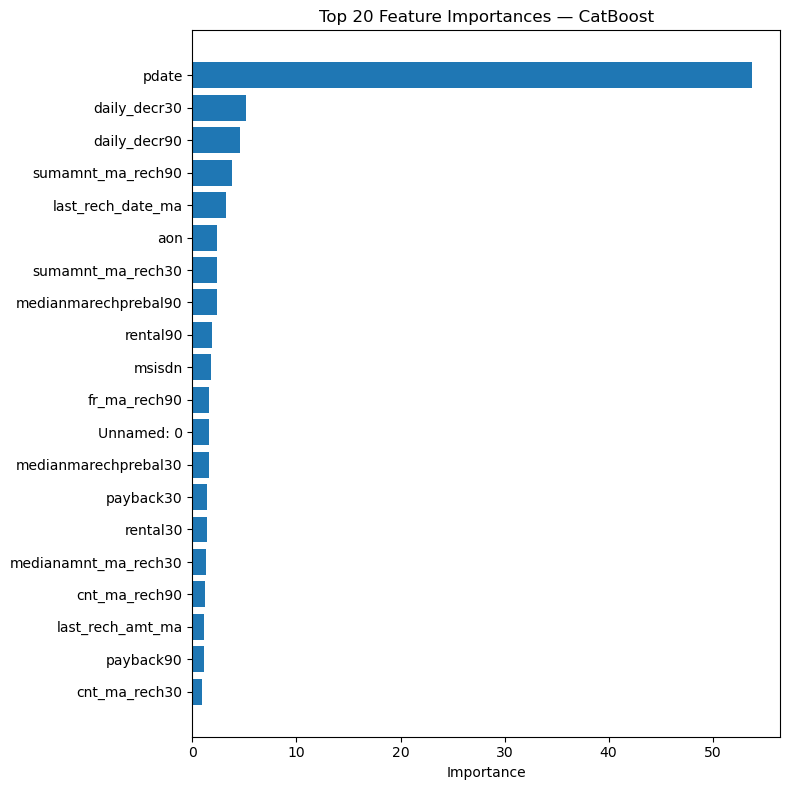

,feature,importance
34,pdate,53.795339
3,daily_decr30,5.103537
4,daily_decr90,4.570670
17,sumamnt_ma_rech90,3.768496
7,last_rech_date_ma,3.269443
2,aon,2.331108
12,sumamnt_ma_rech30,2.314373
19,medianmarechprebal90,2.310612
6,rental90,1.839668
1,msisdn,1.795158


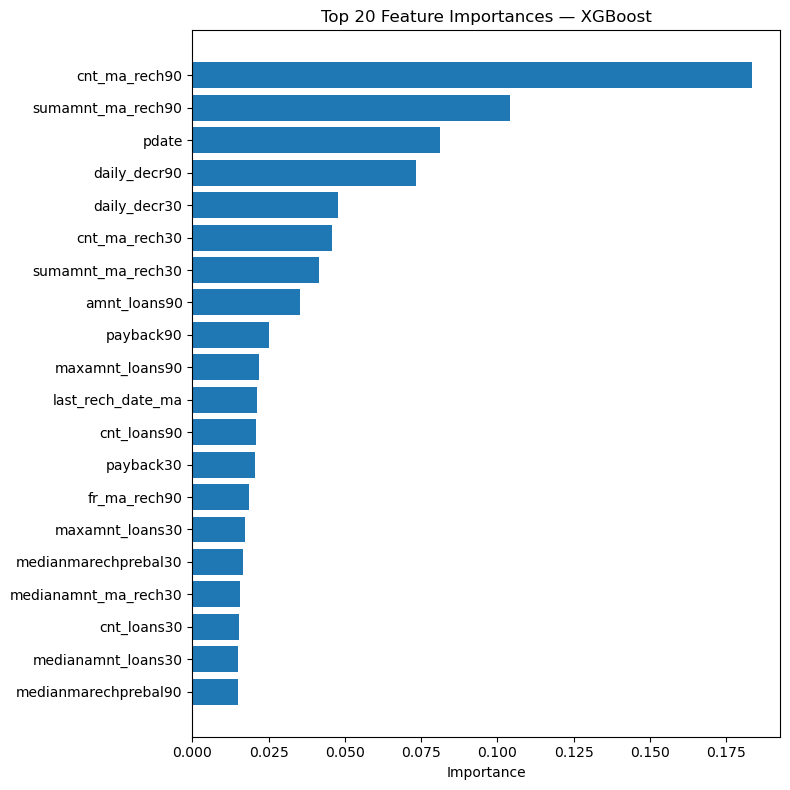

,feature,importance
15,cnt_ma_rech90,0.183513
17,sumamnt_ma_rech90,0.104079
34,pdate,0.081057
4,daily_decr90,0.073465
3,daily_decr30,0.047696
10,cnt_ma_rech30,0.045918
12,sumamnt_ma_rech30,0.041556
29,amnt_loans90,0.035201
33,payback90,0.025176
30,maxamnt_loans90,0.021804


HistGB importance failed: HistGradientBoosting has no feature_importances_ (check sklearn version).


In [17]:
def plot_top_importances(importances, feature_names, model_name, top_n=20):
    """Plot top_n features by importance."""
    imp = np.array(importances, dtype=float)
    names = np.array(feature_names)
    df_imp = pd.DataFrame({"feature": names, "importance": imp})
    df_imp = df_imp.sort_values("importance", ascending=False).head(top_n)[::-1]  # reverse for barh

    plt.figure(figsize=(8, max(6, int(top_n * 0.4))))
    plt.barh(df_imp["feature"], df_imp["importance"])
    plt.title(f"Top {top_n} Feature Importances — {model_name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
    return df_imp.sort_values("importance", ascending=False)

feature_names = getattr(X_train, "columns", np.arange(X_train.shape[1]))

# ---------------------------
# 1) CatBoost importances
# ---------------------------
try:
    from catboost import Pool
    pool_train = Pool(X_train, y_train, feature_names=list(feature_names))
    cat_importances = best_cat.get_feature_importance(pool_train)  # same order as feature_names
    cat_top = plot_top_importances(cat_importances, feature_names, "CatBoost", top_n=20)
    display(cat_top.head(10))
except Exception as e:
    print("CatBoost importance failed:", e)

# ---------------------------
# 2) XGBoost importances
# ---------------------------
try:
    # Sklearn wrapper exposes feature_importances_ aligned with input columns
    xgb_importances = getattr(best_xgb, "feature_importances_", None)
    if xgb_importances is None or np.sum(xgb_importances) == 0:
        # fallback: use booster gain (mapped by position)
        booster = best_xgb.get_booster()
        # This returns dict like {'f0': gain, 'f1': gain, ...}
        gain_dict = booster.get_score(importance_type="gain")
        # Map to column order
        xgb_importances = np.zeros(len(feature_names))
        for i, _ in enumerate(feature_names):
            xgb_importances[i] = gain_dict.get(f"f{i}", 0.0)
    xgb_top = plot_top_importances(xgb_importances, feature_names, "XGBoost", top_n=20)
    display(xgb_top.head(10))
except Exception as e:
    print("XGBoost importance failed:", e)

# ---------------------------
# 3) HistGradientBoosting importances
# ---------------------------
try:
    hgb_importances = getattr(best_histgb, "feature_importances_", None)
    if hgb_importances is None:
        raise ValueError("HistGradientBoosting has no feature_importances_ (check sklearn version).")
    hgb_top = plot_top_importances(hgb_importances, feature_names, "HistGradientBoosting", top_n=20)
    display(hgb_top.head(10))
except Exception as e:
    print("HistGB importance failed:", e)

In [18]:
from sklearn.inspection import permutation_importance

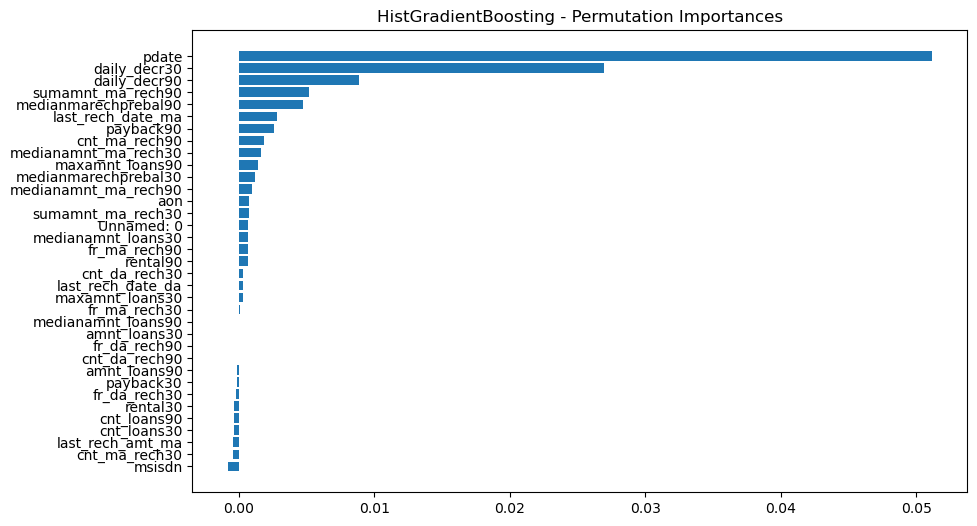

In [19]:
r = permutation_importance(best_histgb, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

sorted_idx = r.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(np.array(X_train.columns)[sorted_idx], r.importances_mean[sorted_idx])
plt.title("HistGradientBoosting - Permutation Importances")
plt.show()

In [20]:
# ===============================================
# 9. FINAL EVALUATION ON BEST MODELS
# ===============================================
best_histgb = histgb_search.best_estimator_
best_xgb = xgb_search.best_estimator_
best_cat = cat_search.best_estimator_

final_models = [("HistGB", best_histgb), ("XGB", best_xgb), ("CatBoost", best_cat)]

for name, model in final_models:
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"{name} LogLoss: {log_loss(y_test, y_prob):.4f}")



HistGB Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.57      0.65       754
         1.0       0.94      0.97      0.96      5246

    accuracy                           0.92      6000
   macro avg       0.84      0.77      0.80      6000
weighted avg       0.92      0.92      0.92      6000

HistGB LogLoss: 0.1951

XGB Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.55      0.64       754
         1.0       0.94      0.98      0.96      5246

    accuracy                           0.92      6000
   macro avg       0.86      0.76      0.80      6000
weighted avg       0.92      0.92      0.92      6000

XGB LogLoss: 0.1934

CatBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.57      0.65       754
         1.0       0.94      0.97      0.96      5246

    accuracy                           0.92    

In [22]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[("HistGB", best_histgb), ("XGB", best_xgb), ("CatBoost", best_cat)],
    voting="soft"
)
ensemble.fit(X_train, y_train)

y_pred_ens = ensemble.predict(X_test)
y_prob_ens = ensemble.predict_proba(X_test)[:, 1]

print("\nEnsemble Classification Report:")
print(classification_report(y_test, y_pred_ens))
print(f"Ensemble LogLoss: {log_loss(y_test, y_prob_ens):.4f}")


Ensemble Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.57      0.65       754
         1.0       0.94      0.98      0.96      5246

    accuracy                           0.92      6000
   macro avg       0.85      0.77      0.80      6000
weighted avg       0.92      0.92      0.92      6000

Ensemble LogLoss: 0.1923


In [24]:
results = []
for name, model in final_models + [("Ensemble", ensemble)]:
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    results.append({
        "Model": name,
        "LogLoss": log_loss(y_test, y_prob),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
    })

results_df = pd.DataFrame(results).sort_values("LogLoss")
print("\nFinal Comparison:\n", results_df)


Final Comparison:
       Model   LogLoss  Precision    Recall
3  Ensemble  0.192332   0.939923  0.975219
1       XGB  0.193360   0.937523  0.978269
2  CatBoost  0.194772   0.940180  0.973694
0    HistGB  0.195125   0.940797  0.972360


In [25]:
import joblib
joblib.dump(ensemble, "final_model.pkl")

['final_model.pkl']